<a href="https://colab.research.google.com/github/CoWoGeo/PUS2022_CWolk/blob/main/ProjectLanthamWolk/LIBusinessLicenses.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Philadelphia L&I Business Licenses

Data and overview here: https://www.opendataphilly.org/dataset/licenses-and-inspections-business-licenses

City's data visualization (with helpful search tool) here: https://data.phila.gov/visualizations/li-business-licenses

This will be the foundational data set for our project. Our core data from this is every site that has ever had a junkyard license, plus every license attached to that parcel. The logic for this is that we know that there are far more operating junkyards than sites with active junkyard licenses (based on news coverage and the Scrapyard Task Force's own report) and there does not seem to be much enforcement of license renewals, so junkyards with lapsed licenses are a logical place to look. 

We also hope to look for sites that have never had junkyard licenses but whose business names and licenses make them likely candidates, such as having auto repair or part licenses and "scrap" or "junk" in the name. This might need to be a later project, though, as the dividing line between an auto repair or used tire place and a junkyard is blurry and we might need to figure out additional criteria such as parcel size, violations, types of complaints, etc.

## Order of operations:


1.   Import business licenses dataset
2.   Remove irrelevant columns, clean up rows with significant NaNs
3. Find most common irrelevant business license type (in this case, Rental) and remove it from the dataframe to make it smaller and more manageable
4. Extract all sites that have ever had junkyard licenses
5. Extract all sites that have active junkyard licenses for numeric context
6. Find a column to use to find all licenses for junkyard sites. This ended up being the geometry column because no other column was reliable or complete enough.
7. Create a geodataframe of sites with junkyard licenses and all other licenses for those locations.
8. Import Philadelphia Department of Records Parcel shapefile. 
9. Use Philadelphia Department of Records Parcels to merge correct parcel data and street addresses with license locations, replace point geometry of business licenses with parcel shape geometry.
10. Probably download this dataset and upload it to Google Drive so that we can use it in other notebooks without having to rerun all the very slow imports and loops.
11. Do some data analysis on the types of licenses and data quality.



# Importing and Installing Libraries

In [2]:
!apt install python3-rtree

Reading package lists... Done
Building dependency tree       
Reading state information... Done
python3-rtree is already the newest version (0.8.3+ds-1).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 20 not upgraded.


In [3]:
! pip install shapely

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
!pip install cartoframes

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [5]:
!pip install geopandas
import geopandas as gpd

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
import pandas as pd

In [7]:
import cartoframes as cf

In [8]:
import matplotlib.pyplot as plt

In [9]:
from shapely.geometry import Point

In [10]:
import numpy as np

# Importing and Exploring Business Licenses Data

In [11]:
licenses = gpd.GeoDataFrame.from_file("https://phl.carto.com/api/v2/sql?q=SELECT+*+FROM+business_licenses&filename=business_licenses&format=shp&skipfields=cartodb_id")

In [12]:
#I really want to edit the link to import just the columns I want and cut the
#rental licenses before importing them to save time and storage. But how?
#licenses = gpd.GeoDataFrame.from_file("https://phl.carto.com/api/v2/sql?q=SELECT+*+FROM+business_licenses&filename=business_licenses&format=shp&skipfields=cartodb_id&WHERE+licensetyp==Rental=False)

In [13]:
licenses.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 395189 entries, 0 to 395188
Data columns (total 42 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   objectid    395189 non-null  int64   
 1   addressobj  375407 non-null  float64 
 2   address     377931 non-null  object  
 3   unit_type   115926 non-null  object  
 4   unit_num    115391 non-null  object  
 5   zip         377905 non-null  object  
 6   censustrac  377408 non-null  object  
 7   parcel_id_  376098 non-null  object  
 8   opa_accoun  367731 non-null  object  
 9   opa_owner   367476 non-null  object  
 10  licensenum  395189 non-null  object  
 11  revenuecod  395189 non-null  object  
 12  licensetyp  395189 non-null  object  
 13  rentalcate  229837 non-null  object  
 14  initialiss  395189 non-null  object  
 15  mostrecent  395189 non-null  object  
 16  expiration  386103 non-null  object  
 17  inactiveda  227313 non-null  object  
 18  licensesta  3951

## Cleaning Business License Data

Here is the metadata page: https://metadata.phila.gov/#home/datasetdetails/5543865a20583086178c4ed2/representationdetails/5e985a5e344ed50018936bb8/

A useful explanation for OPA Account Number: "Office of Property Assessment Account Number' Every land parcel within the City of Philadelphia is assigned a unique account number from OPA. This number stays with the property for as long as the deed is held by the same owner. Once a property transfers ownership, it is assigned a new OPA account number and the old one is retired.

"This field can be used as a join key for various city datasets. It is also sometimes known as the 'BRT' number or within some datasets coming directly from OPA is also called the 'PARCEL_NUMBER'. (Other departments may use different internal 'Parcel Numbers', so please verify before using)"

This is both incredibly confusing/messy and useful: multiple OPA Account Numbers being tagged to the same address will show us that the property changed hands. (This is often very slow to show up in records, in my experience, though!)

POSSE JOBI: "Objectid and join field for related records" But there are other fields they say are join fields and other objectids!

In [14]:
# drop multiple columns by index, dropping all this owner contact info
cols  = licenses.columns
licenses.drop(columns =cols[27:37], inplace=True)

In [15]:
#dropping columns related to housing rental licenses
licenses = licenses.drop(columns=["numberofun", "owneroccup"], axis=1)

In [16]:
licenses.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 395189 entries, 0 to 395188
Data columns (total 30 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   objectid    395189 non-null  int64   
 1   addressobj  375407 non-null  float64 
 2   address     377931 non-null  object  
 3   unit_type   115926 non-null  object  
 4   unit_num    115391 non-null  object  
 5   zip         377905 non-null  object  
 6   censustrac  377408 non-null  object  
 7   parcel_id_  376098 non-null  object  
 8   opa_accoun  367731 non-null  object  
 9   opa_owner   367476 non-null  object  
 10  licensenum  395189 non-null  object  
 11  revenuecod  395189 non-null  object  
 12  licensetyp  395189 non-null  object  
 13  rentalcate  229837 non-null  object  
 14  initialiss  395189 non-null  object  
 15  mostrecent  395189 non-null  object  
 16  expiration  386103 non-null  object  
 17  inactiveda  227313 non-null  object  
 18  licensesta  3951

In [17]:
licensetype = licenses["licensetyp"]
licensetype.describe()

count     395189
unique        53
top       Rental
freq      252040
Name: licensetyp, dtype: object

There are 53 types of licenses in the data set, with Rental as the most frequent. Rental isn't relevant to us!

In [18]:
# Removing the many Rental records from the dataframe
licenses = licenses[licenses["licensetyp"].str.contains("Rental") == False]

In [19]:
licenses.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 143149 entries, 2 to 395184
Data columns (total 30 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   objectid    143149 non-null  int64   
 1   addressobj  123721 non-null  float64 
 2   address     126440 non-null  object  
 3   unit_type   36602 non-null   object  
 4   unit_num    36394 non-null   object  
 5   zip         126439 non-null  object  
 6   censustrac  126252 non-null  object  
 7   parcel_id_  125017 non-null  object  
 8   opa_accoun  122186 non-null  object  
 9   opa_owner   122002 non-null  object  
 10  licensenum  143149 non-null  object  
 11  revenuecod  143149 non-null  object  
 12  licensetyp  143149 non-null  object  
 13  rentalcate  0 non-null       object  
 14  initialiss  143149 non-null  object  
 15  mostrecent  143149 non-null  object  
 16  expiration  134063 non-null  object  
 17  inactiveda  79215 non-null   object  
 18  licensesta  1431

In [20]:
licensetype.describe()

count     395189
unique        53
top       Rental
freq      252040
Name: licensetyp, dtype: object

The next most frequent is "Vacant Residential Property / Lot." We need this for later because fly-by-night scrapyards are likely on vacant lots, but we don't need it now. Now we know that there are 34,955 vacant lots in Philadelphia!

Before, I had left a lot of columns in at this stage, but now that I've explored the data a lot and at Fed's urging, I'll drop more. I am keeping other non-essential columns for the data exploration aspect and to show the steps I took to choose a process.

In [21]:
licenses = licenses.drop(columns=["unit_type", "unit_num", "rentalcate",
                                  "council_di", "posse_jobi"], axis=1)

In [22]:
licenses.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 143149 entries, 2 to 395184
Data columns (total 25 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   objectid    143149 non-null  int64   
 1   addressobj  123721 non-null  float64 
 2   address     126440 non-null  object  
 3   zip         126439 non-null  object  
 4   censustrac  126252 non-null  object  
 5   parcel_id_  125017 non-null  object  
 6   opa_accoun  122186 non-null  object  
 7   opa_owner   122002 non-null  object  
 8   licensenum  143149 non-null  object  
 9   revenuecod  143149 non-null  object  
 10  licensetyp  143149 non-null  object  
 11  initialiss  143149 non-null  object  
 12  mostrecent  143149 non-null  object  
 13  expiration  134063 non-null  object  
 14  inactiveda  79215 non-null   object  
 15  licensesta  143149 non-null  object  
 16  legalfirst  51192 non-null   object  
 17  legallastn  51190 non-null   object  
 18  legalname   1429

# Junkyards and Associated Licenses!

## Creating a dataframe of just junkyard licenses aka LicensedJunk

In a future, more detailed version of this project, we'd search by business name and then search them online to find businesses that are clearly junkyards/scrapyards but have never had a license for it, and/or try to differentiate between licensed junkyards that are truly more of a small auto repair shop than primarily about junk. Philly also has a huge overlapping problem of businesses getting auto repair shop licenses and zoning exemptions to operate in residential areas and then operating as more of a junkyard. (There are several walking distance from Coryn's house!)

In [22]:
licensedjunk = licenses[licenses["licensetyp"].str.contains("Auto Wrecking / Junk Yard")]

In [23]:
licensedjunk.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 274 entries, 11883 to 394191
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   objectid    274 non-null    int64   
 1   addressobj  270 non-null    float64 
 2   address     270 non-null    object  
 3   zip         270 non-null    object  
 4   censustrac  270 non-null    object  
 5   parcel_id_  239 non-null    object  
 6   opa_accoun  230 non-null    object  
 7   opa_owner   230 non-null    object  
 8   licensenum  274 non-null    object  
 9   revenuecod  274 non-null    object  
 10  licensetyp  274 non-null    object  
 11  initialiss  274 non-null    object  
 12  mostrecent  274 non-null    object  
 13  expiration  274 non-null    object  
 14  inactiveda  186 non-null    object  
 15  licensesta  274 non-null    object  
 16  legalfirst  99 non-null     object  
 17  legallastn  99 non-null     object  
 18  legalname   274 non-null    object 

I could have just done that to start with, but all the datacleaning above will make the licenses dataframe smaller and easier to work with in future steps.

In [24]:
# looking at rows without geometry
nogeometry = licensedjunk[licensedjunk["geometry"].isna()]
nogeometry

objectid  addressobj address   zip censustrac parcel_id_ opa_accoun  \
85580      84641         NaN    None  None       None       None       None   
100270     97271         NaN    None  None       None       None       None   
103030    106574         NaN    None  None       None       None       None   
105585    104242         NaN    None  None       None       None       None   

       opa_owner licensenum revenuecod  ... licensesta legalfirst legallastn  \
85580       None     287719       3374  ...   Inactive       None       None   
100270      None     311520       3374  ...   Inactive      KEVIN    CREEDON   
103030      None     327115       3374  ...   Inactive       None       None   
105585      None     323045       3374  ...   Inactive       None       None   

                       legalname  legalentit                business_n  \
85580          LAM AUTO SALES CO     Company         LAM AUTO SALES CO   
100270             CREEDON KEVIN  Individual    KEVINS USED AUTO PARTS   
103030    PORT RICHMOND AUTO INC     Company    PORT RICHMOND AUTO INC   
105585  KNOCK OUT AUTO PARTS LLC     Company  KNOCK OUT AUTO PARTS LLC   

                                              business_m geocode_x geocode_y  \
85580   1901 WESTMORELAND ST PHILADELPHIA, PA  19140 USA       NaN       NaN   
100270      423 W LUZERNE ST PHILADELPHIA, PA  19140 USA       NaN       NaN   
103030        3950 N DELAWARE AVE PHILADELPHIA, PA   USA       NaN       NaN   
105585       3201 E TIOGA ST PHILADELPHIA, PA  19134 USA       NaN       NaN   

       geometry  
85580      None  
100270     None  
103030     None  
105585     None  

[4 rows x 25 columns]

An illustration of how messy this data is! I looked up Kevin's Used Auto Parts, one of the entries missing most of the data and with an inactive Junk Yard license, in the city API and found a second entry with the same business name and an inactive license for towing. However, that business had the address of 990 Spring Garden St, which is a real estate company. I searched 423 W. Luzerne St and got a few auto parts companies with no obvious name. However, satellite images show some junkyards at the pin for 423 W. Luzerne St. (Incidentally, next to a police station.) Then I searched the owner, Kevin Creedon, and found another inactive junkyard license for 	4085 RICHMOND ST and a license at 4087 Richmond St. There is nothing there because it is the little space between Richmond St, Frankford Creek, and multiple freight rail lines.

*   1901 WESTMORELAND ST/Lam Auto Sales: Inactive. There is also a closed business license for Lam Auto Sales "Motor Vehicle Repair / Retail Mobile Dispensing" at that address with more data. Google Streetview shows a raggedy abandoned-looking warehouse.

*   3201 E. Tioga/Knock Out Auto Parts: No other entries. It's sort of a vacant lot by the PRPA HQ. There's another auto shop on that same big lot, but it has a different address and its own entry.

*   3950 N DELAWARE AVE PHILADELPHIA / Port Richmond Auto Company: No other entries for that address, searching the name comes up with 4085 RICHMOND ST, which has an inactive junk yard license with the same business name. 4085 Richmond St is the same creekside address as above, but this is a different entry!

3950 Delaware Ave: Aha! This is an alias for 3950 N. Delaware Ave. Google maps actually shows a big scrapyard here. There are active junkyard and hazmat materials licenses for a company called "Final Destination, Inc." using this address as their business license and 4085 as their location. Very creepy. They are actually there on Google Streetview, though. Their licenses seem to overlap with the other licenses at 4085 Richmond St.

4000 N. Delaware Ave: another 4085 Richmond St location is registered here. Searching that address gets 3 licenses for another business, A AND B Scrap Metal at 9200 JAMES ST up in the Holmesburg neighborhood. These are all inactive, but there looks to be a junkyard attached to a few autobody/used car shops at 9200-9240 James St. Searching that census tract returns a ton of inactive licenses for various businesses, some property rental licenses, and an active dumpster license.

This tells me that I don't really need to worry about including these because the information is basically redundant with rows that do have geometry and just adds more confusion to the data.


In [25]:
#deleting those 4 null rows
licensedjunk = licensedjunk[licensedjunk["geometry"].notna()]

So now I have 269 rows. However, this doesn't necessarily mean 269 unique locations, because the data is so bad and a site can have multiple entries for licenses that stopped and started or changed names.

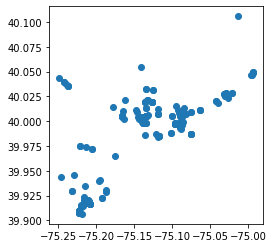

In [26]:
#plotting it just to look, not a great plot!
licensedjunk.plot()

In [27]:
#just a little exploration of license status
licensedjunk["licensesta"].head()



11883    Inactive
12077    Inactive
85092    Inactive
85093    Inactive
85095    Inactive
Name: licensesta, dtype: object

## Getting Every License Attached to Known Junkyard Locations aka Junkyards_lic

In [28]:
#discovering that object ID won't pull everything related to a location.
testrun = licenses[licenses["objectid"] == 363387]
testrun

objectid  addressobj             address         zip censustrac  \
361296    363387  15410490.0  2335 WHEATSHEAF LN  19137-1025        382   

       parcel_id_ opa_accoun     opa_owner licensenum revenuecod  ...  \
361296     295956  884195003  NGUYEN APRIL     846057       3374  ...   

       licensesta legalfirst legallastn                    legalname  \
361296     Active       None       None  HELPING HANDS RECYCLING INC   

       legalentit                   business_n  \
361296    Company  HELPING HANDS RECYCLING INC   

                                            business_m     geocode_x  \
361296  2335 WHEATSHEAF LN PHILADELPHIA, PA  19137 USA  2.713581e+06   

            geocode_y                    geometry  
361296  253759.308312  POINT (-75.09015 39.99912)  

[1 rows x 25 columns]

In [29]:
#addressobj is better than object ID
testrun2 = licenses[licenses["addressobj"] == 15410490.0]
testrun2

objectid  addressobj             address         zip censustrac  \
79117      79302  15410490.0  2335 WHEATSHEAF LN  19137-1025        382   
80270      81275  15410490.0  2335 WHEATSHEAF LN  19137-1025        382   
83216      83661  15410490.0  2335 WHEATSHEAF LN  19137-1025        382   
187122    175931  15410490.0  2335 WHEATSHEAF LN  19137-1025        382   
187123    175932  15410490.0  2335 WHEATSHEAF LN  19137-1025        382   
187124    175933  15410490.0  2335 WHEATSHEAF LN  19137-1025        382   
192441    190906  15410490.0  2335 WHEATSHEAF LN  19137-1025        382   
192442    190907  15410490.0  2335 WHEATSHEAF LN  19137-1025        382   
268153    267860  15410490.0  2335 WHEATSHEAF LN  19137-1025        382   
297122    301727  15410490.0  2335 WHEATSHEAF LN  19137-1025        382   
361296    363387  15410490.0  2335 WHEATSHEAF LN  19137-1025        382   
361297    363388  15410490.0  2335 WHEATSHEAF LN  19137-1025        382   
361298    363389  15410490.0  2335 WHEATSHEAF LN  19137-1025        382   

       parcel_id_ opa_accoun     opa_owner licensenum revenuecod  ...  \
79117      295956  884195003  NGUYEN APRIL     281318       3230  ...   
80270      295956  884195003  NGUYEN APRIL     283318       3311  ...   
83216      295956  884195003  NGUYEN APRIL     285948       3335  ...   
187122     295956  884195003  NGUYEN APRIL     474389       3311  ...   
187123     295956  884195003  NGUYEN APRIL     474391       3230  ...   
187124     295956  884195003  NGUYEN APRIL     474392       3335  ...   
192441     295956  884195003  NGUYEN APRIL     507947       3822  ...   
192442     295956  884195003  NGUYEN APRIL     507948       3822  ...   
268153     295956  884195003  NGUYEN APRIL     658318       3335  ...   
297122     295956  884195003  NGUYEN APRIL     723987       3374  ...   
361296     295956  884195003  NGUYEN APRIL     846057       3374  ...   
361297     295956  884195003  NGUYEN APRIL     846058       3335  ...   
361298     295956  884195003  NGUYEN APRIL     846059       3822  ...   

       licensesta legalfirst legallastn                          legalname  \
79117    Inactive       None       None               ATLANTIC SYSTEMS INC   
80270    Inactive       None       None               ATLANTIC SYSTEMS INC   
83216    Inactive       None       None               ATLANTIC SYSTEMS INC   
187122   Inactive       None       None  DIVERSIFIED TOWING & RECOVERY INC   
187123   Inactive       None       None  DIVERSIFIED TOWING & RECOVERY INC   
187124   Inactive       None       None  DIVERSIFIED TOWING & RECOVERY INC   
192441   Inactive       None       None             GREENDOG RECYCLING INC   
192442   Inactive       None       None             GREENDOG RECYCLING INC   
268153   Inactive       None       None             GREENDOG RECYCLING INC   
297122   Inactive       None       None             GREENDOG RECYCLING INC   
361296     Active       None       None        HELPING HANDS RECYCLING INC   
361297     Active       None       None        HELPING HANDS RECYCLING INC   
361298     Active       None       None        HELPING HANDS RECYCLING INC   

       legalentit                         business_n  \
79117     Company               ATLANTIC SYSTEMS INC   
80270     Company               ATLANTIC SYSTEMS INC   
83216     Company               ATLANTIC SYSTEMS INC   
187122    Company  DIVERSIFIED TOWING & RECOVERY INC   
187123    Company  DIVERSIFIED TOWING & RECOVERY INC   
187124    Company  DIVERSIFIED TOWING & RECOVERY INC   
192441    Company             GREENDOG RECYCLING INC   
192442    Company             GREENDOG RECYCLING INC   
268153    Company             GREENDOG RECYCLING INC   
297122    Company             GREENDOG RECYCLING INC   
361296    Company        HELPING HANDS RECYCLING INC   
361297    Company        HELPING HANDS RECYCLING INC   
361298    Company        HELPING HANDS RECYCLING INC   

                                              business_m

In [30]:
#gathering licenses by matching by business name
licensedjunk_bizname = licenses[licenses.business_n.isin(licensedjunk["business_n"])]
licensedjunk_bizname.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 826 entries, 11883 to 394191
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   objectid    826 non-null    int64   
 1   addressobj  739 non-null    float64 
 2   address     751 non-null    object  
 3   zip         751 non-null    object  
 4   censustrac  751 non-null    object  
 5   parcel_id_  709 non-null    object  
 6   opa_accoun  689 non-null    object  
 7   opa_owner   689 non-null    object  
 8   licensenum  826 non-null    object  
 9   revenuecod  826 non-null    object  
 10  licensetyp  826 non-null    object  
 11  initialiss  826 non-null    object  
 12  mostrecent  826 non-null    object  
 13  expiration  798 non-null    object  
 14  inactiveda  489 non-null    object  
 15  licensesta  826 non-null    object  
 16  legalfirst  213 non-null    object  
 17  legallastn  213 non-null    object  
 18  legalname   826 non-null    object 

In [31]:
# matching by address obj
licensedjunk_adreso = licenses[licenses.addressobj.isin(licensedjunk["addressobj"])]
licensedjunk_adreso.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 765 entries, 418 to 394191
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   objectid    765 non-null    int64   
 1   addressobj  765 non-null    float64 
 2   address     765 non-null    object  
 3   zip         765 non-null    object  
 4   censustrac  765 non-null    object  
 5   parcel_id_  718 non-null    object  
 6   opa_accoun  691 non-null    object  
 7   opa_owner   691 non-null    object  
 8   licensenum  765 non-null    object  
 9   revenuecod  765 non-null    object  
 10  licensetyp  765 non-null    object  
 11  initialiss  765 non-null    object  
 12  mostrecent  765 non-null    object  
 13  expiration  728 non-null    object  
 14  inactiveda  424 non-null    object  
 15  licensesta  765 non-null    object  
 16  legalfirst  214 non-null    object  
 17  legallastn  214 non-null    object  
 18  legalname   765 non-null    object  


I get more unique address objects when I match by business name and more unique business names when I match by address object, which means that either method misses some of the other. However, it's not clear whether all those uniques are important because this dataset has a lot of redundancies, inconsistent data entries for the same info, and simply messy info.

First, I compare how many unique address obj I get by matching licenses to the business name of the junkyard vs by matching licenses to the address obj of the junkyard.

In [32]:
# I get more unique address obj when I match by business names.
licensedjunk_bizname["addressobj"].nunique()

199

In [33]:
#same number of of unique addressobj as in licensedjunk. Except licensedjunk 
#had 269 licenses. Is that a good sign?
licensedjunk_adreso["addressobj"].nunique()

144

In [34]:
#unique business names matching by business name
licensedjunk_bizname["business_n"].nunique()

244

In [35]:
#unique business names matching by address obj. Way more!
licensedjunk_adreso["business_n"].nunique()

384

In [36]:
licensedjunk_bizname["geometry"].nunique()

172

In [37]:
licensedjunk_adreso["geometry"].nunique()

126

Above, you can see that parcel values are a mess!!! Non uniform string length, negative numbers, missing values... Parcel -884790010 is actually that business's OPA account id. I used the data visualization tool to explore how parcels and addresses are used throughout the dataset and found many parcel IDs switched with OPA accounts, but not consistently enough to use that to fix it, especially as the OPA account data has its own problems (see below).

Gah, neither of these is an obvious choice to capture all the information. Though number of unique in either category doesn't necessarily guarantee a more complete dataset. The uniqueness can just be typos, different spellings, redundancies, mixups of information, etc that add disorder without adding relevant information. Geometry is more computationally intense but seems like the safest match given the holes and inconsistencies in address object and business name. The risk is if points are misentered in such a way that they won't match for the same location, but the results should tell me if that's a huge problem.

In [38]:
# matching licenses by geometry
junkyards_lic = licenses[licenses.geometry.isin(licensedjunk["geometry"])]

In [39]:
junkyards_lic.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 866 entries, 418 to 394191
Data columns (total 25 columns):
 #   Column      Non-Null Count  Dtype   
---  ------      --------------  -----   
 0   objectid    866 non-null    int64   
 1   addressobj  844 non-null    float64 
 2   address     866 non-null    object  
 3   zip         866 non-null    object  
 4   censustrac  866 non-null    object  
 5   parcel_id_  819 non-null    object  
 6   opa_accoun  791 non-null    object  
 7   opa_owner   791 non-null    object  
 8   licensenum  866 non-null    object  
 9   revenuecod  866 non-null    object  
 10  licensetyp  866 non-null    object  
 11  initialiss  866 non-null    object  
 12  mostrecent  866 non-null    object  
 13  expiration  821 non-null    object  
 14  inactiveda  476 non-null    object  
 15  licensesta  866 non-null    object  
 16  legalfirst  233 non-null    object  
 17  legallastn  233 non-null    object  
 18  legalname   866 non-null    object  


Wooo, there are more unique business names in this matching strategy than the others, so I probably didn't lose useful data.

In [40]:
junkyards_lic["geometry"].nunique()

126

In [41]:
junkyards_lic["business_n"].nunique()

422

I imported the Philadelphia parcel data/map to compare it to this. On https://atlas.phila.gov/3100%20S%2061ST%20ST I figured out that one location with an OPA account as its parcel number has the official parcel number 047S220022. In the parcel dataset, that is in the MAPREG column. More below...

# Connecting Licenses and Parcels Prelude

## Philly Parcels GeoDataframe

Now that I have all the locations with known junkyard licenses and all their relevant permits (I hope!), I'm going to add those parcel columns from the parcel dataset. I think it'll make it easier if I do this before I add in all the violations.

MAPREG is the column in the parcel dataset that matches the parcel section of Atlas Philly (the public website of Philly real estate data and deeds) https://atlas.phila.gov/. The PARCEL column in business licenses is very strange (apparently negatives aren't an aberration) and doesn't match this dataset at all, column-wise. I can't use PARCEL columns or street addresses (also a mess) to join the business licenses to any other dataset. However, the business license data is points and the parcel data is shapes/polygons, so I should be able to connect them by business license locations that fall within parcel polygons.

The Philly Parcels dataset is huge! After importing it once, I imported only a conservative estimate of the columns I think I might need.

In [23]:
#importing Philly Parcel data, with only useful columns
phillyparcels = gpd.GeoDataFrame.from_file("https://opendata.arcgis.com/datasets/1c57dd1b3ff84449a4b0e3fb29d3cafd_0.zip")[["ADDR_SOURC", "MAPREG", 
                                       "RECMAP", "PARCEL",
                                        "PWD_REVIEW", "DOR_REVIEW", "geometry"]]

In [24]:
phillyparcels.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 606512 entries, 0 to 606511
Data columns (total 7 columns):
 #   Column      Non-Null Count   Dtype   
---  ------      --------------   -----   
 0   ADDR_SOURC  600298 non-null  object  
 1   MAPREG      606355 non-null  object  
 2   RECMAP      606344 non-null  object  
 3   PARCEL      606144 non-null  object  
 4   PWD_REVIEW  25097 non-null   object  
 5   DOR_REVIEW  25439 non-null   object  
 6   geometry    606486 non-null  geometry
dtypes: geometry(1), object(6)
memory usage: 32.4+ MB


# Projecting Layers

# Joining Simple Junkyard License Info to Parcels for Export

I used the resulting dataframe for the L&I violations notebook.

# Finding all those firey junkyards without licenses

In [27]:
fires = pd.read_csv("https://raw.githubusercontent.com/CoWoGeo/PUS2022_CWolk/main/ProjectLanthamWolk/PhillyFireLocations.csv")

In [28]:
fires

company_name has_junkyard_license  \
0                               Titan Auto Recycling                  Yes   
1                               Titan Auto Recycling                  Yes   
2                                SD Richman and Sons                  Yes   
3   Waste Management - Philadelphia Transfer Station                   No   
4                               Nicholas Scrap Metal                  Yes   
5                          Delaware Valley Recycling                   No   
6    Multiple - ABM Automotive or AL's Auto Services                   No   
7                            Gold Medal Enviomental                    No   
8                              McCarthy Tire Service                   No   
9                                        Thim Export                   No   
10                             Orthodox Auto Company                  Yes   
11                          EMR Philadelphia - Delco                   No   
12                                  101 W VENANGO ST                   No   
13          Philadelphia Metal and Resource Recovery                  Yes   
14           H&H Auto Sales and Repair Services Inc.                  Yes   
15                    Multiple - 6030 W Passyunk Ave                  Yes   
16                          Allegheny Iron and Metal                   No   
17                             Big Head Auto Salvage                   No   

   parcel_full has_any_licenses  has_hazmat_license  
0   044N080163              Yes                 NaN  
1   044N070161              Yes                 NaN  
2   078N150014              Yes                 NaN  
3   009S090011              Yes                 NaN  
4   101N070226              Yes                 NaN  
5   047S220031              Yes                 NaN  
6   023S090332              Yes                 NaN  
7   037S090011              Yes                 NaN  
8   025N150065               No                 NaN  
9   116N030022              yes                 NaN  
10  111N220010              Yes                 NaN  
11  037N160051               No                 NaN  
12  045N150032               No                 NaN  
13  066N100089              Yes                 NaN  
14  044N080163              Yes                 NaN  
15  050S210035              Yes                 NaN  
16  083N050014              Yes                 NaN  
17  047S230011              Yes                 NaN

In [29]:
# renaming parcel column back to old name for merge
fires.rename({"parcel_full":"MAPREG"}, axis=1, inplace=True)

In [30]:
#merging with parcel geometry
fireparcels = fires.merge(phillyparc_proj, on="MAPREG", how="inner")

In [31]:
fireparcels

company_name has_junkyard_license  \
0                               Titan Auto Recycling                  Yes   
1            H&H Auto Sales and Repair Services Inc.                  Yes   
2                               Titan Auto Recycling                  Yes   
3                                SD Richman and Sons                  Yes   
4   Waste Management - Philadelphia Transfer Station                   No   
5                               Nicholas Scrap Metal                  Yes   
6                          Delaware Valley Recycling                   No   
7    Multiple - ABM Automotive or AL's Auto Services                   No   
8                            Gold Medal Enviomental                    No   
9                              McCarthy Tire Service                   No   
10                                       Thim Export                   No   
11                             Orthodox Auto Company                  Yes   
12                          EMR Philadelphia - Delco                   No   
13                                  101 W VENANGO ST                   No   
14          Philadelphia Metal and Resource Recovery                  Yes   
15                    Multiple - 6030 W Passyunk Ave                  Yes   
16                          Allegheny Iron and Metal                   No   
17                             Big Head Auto Salvage                   No   

        MAPREG has_any_licenses  has_hazmat_license              ADDR_SOURC  \
0   044N080163              Yes                 NaN       390 W SEDGLEY AVE   
1   044N080163              Yes                 NaN       390 W SEDGLEY AVE   
2   044N070161              Yes                 NaN       390 W SEDGLEY AVE   
3   078N150014              Yes                 NaN      2435 WHEATSHEAF LN   
4   009S090011              Yes                 NaN    3651 GRAYS FERRY AVE   
5   101N070226              Yes                 NaN        3812 OLD YORK RD   
6   047S220031              Yes                 NaN                    None   
7   023S090332              Yes                 NaN           246 S 59TH ST   
8   037S090011              Yes                 NaN          1620 S 49TH ST   
9   025N150065               No                 NaN         3465 MELVALE ST   
10  116N030022              yes                 NaN  6801R NEW STATE RD # D   
11  111N220010              Yes                 NaN       5247-57 UNRUH AVE   
12  037N160051               No                 NaN     178 W CLEARFIELD ST   
13  045N150032               No                 NaN         3600 N FRONT ST   
14  066N100089              Yes                 NaN      2200 E SOMERSET ST   
15  050S210035              Yes                 NaN     2600 W PASSYUNK AVE   
16  083N050014              Yes                 NaN          2200 ADAMS AVE   
17  047S230011              Yes                 NaN          3225 S 61ST ST   

    RECMAP PARCEL PWD_REVIEW DOR_REVIEW  \
0   044N08   0163       None       None   
1   044N08   0163       None       None   
2   044N07   0161       None       None   
3   078N15   0014       None       None   
4   009S09   0011       None       None   
5   101N07   0226       None       None   
6   047S22   0031       None       None   
7   023S09   0332       None       None   
8   037S09   0011       None       None   
9   025N15   0065       None       None   
10  116N03   0022       None       None   
11  111N22   0010       None       None   
12  037N16   0051       None       None   
13  045N15   0032       None       None   
14  066N10   0089       None       None   
15  050S21   0035       None       None   
16  083N05   0014       None       None   
17  047S23   0011       None       None   

                                             geometry  
0   POLYGON ((2700968.775 255483.242, 2700835.206 ...  
1   POLYGON ((2700968.775 255483.242, 2700835.206 ...  
2   POLYGON ((2701140.433 255796.897, 2701143.248 ...  
3   POLYGON ((2715170.058 252783

In [32]:
fireparcels.drop(columns=(["has_any_licenses", "has_hazmat_license"]), inplace=True)

In [33]:
fireparcels.drop_duplicates(subset="MAPREG", inplace=True)

In [34]:
fireparcels.reset_index(drop=True, inplace=True)

In [36]:
fireparcels = gpd.GeoDataFrame(fireparcels,  geometry = "geometry")

In [37]:
print("The CRS of business licenses is", licenses.crs, "and the CRS of the fires is", fireparcels.crs)

The CRS of business licenses is epsg:4326 and the CRS of the fires is EPSG:2272


Ugh, I guess I have to project all the business licenses, because what I projected for the junkyard licenses is missing data we need here.

In [38]:
licenses = licenses.to_crs(2272)

In [39]:
# spatial joining fires and licenses to 
firelicenses = fireparcels.sjoin(licenses, how="left")

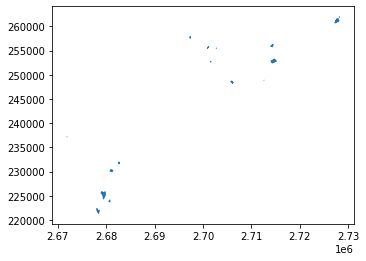

In [40]:
#ok good it's in shape!
firelicenses.plot()

In [41]:
firelicenses.head()

company_name has_junkyard_license      MAPREG         ADDR_SOURC  \
0  Titan Auto Recycling                  Yes  044N080163  390 W SEDGLEY AVE   
0  Titan Auto Recycling                  Yes  044N080163  390 W SEDGLEY AVE   
0  Titan Auto Recycling                  Yes  044N080163  390 W SEDGLEY AVE   
0  Titan Auto Recycling                  Yes  044N080163  390 W SEDGLEY AVE   
0  Titan Auto Recycling                  Yes  044N080163  390 W SEDGLEY AVE   

   RECMAP PARCEL PWD_REVIEW DOR_REVIEW  \
0  044N08   0163       None       None   
0  044N08   0163       None       None   
0  044N08   0163       None       None   
0  044N08   0163       None       None   
0  044N08   0163       None       None   

                                            geometry  index_right  ...  \
0  POLYGON ((2700968.775 255483.242, 2700835.206 ...     262729.0  ...   
0  POLYGON ((2700968.775 255483.242, 2700835.206 ...     243972.0  ...   
0  POLYGON ((2700968.775 255483.242, 2700835.206 ...     384910.0  ...   
0  POLYGON ((2700968.775 255483.242, 2700835.206 ...      85817.0  ...   
0  POLYGON ((2700968.775 255483.242, 2700835.206 ...     241669.0  ...   

   inactiveda  licensesta legalfirst legallastn  \
0  2015-03-01    Inactive       None       None   
0  2022-03-01    Inactive       None       None   
0        None      Active       None       None   
0  2007-03-08    Inactive     MERLIN       CRUZ   
0        None      Active       None       None   

                                  legalname  legalentit  \
0  H & H AUTO SALES AND REPAIR SERVICES INC     Company   
0                    FRANK'S AUTO PARTS LLC     Company   
0                  TITAN AUTO RECYCLING LLC     Company   
0                               CRUZ MERLIN  Individual   
0  H & H AUTO SALES AND REPAIR SERVICES INC     Company   

                                 business_n  \
0  H & H AUTO SALES AND REPAIR SERVICES INC   
0                    FRANK'S AUTO PARTS LLC   
0                  TITAN AUTO RECYCLING LLC   
0                                T/A MERLIN   
0  H & H AUTO SALES AND REPAIR SERVICES INC   

                                          business_m     geocode_x  \
0  390 WEST SEDGLEY AVENUE PHILADELPHIA, PA  1914...  2.701004e+06   
0      390 W SEDGLEY AVE PHILADELPHIA, PA  19140 USA  2.701004e+06   
0      390 w sedgley ave philadelphia, PA  19140 USA  2.701004e+06   
0        390 SEDGLEY AVE PHILADELPHIA, PA  19140 USA  2.701004e+06   
0  390 WEST SEDGLEY AVENUE PHILADELPHIA, PA  1914...  2.701004e+06   

       geocode_y  
0  255607.650042  
0  255607.650042  
0  255607.650042  
0  255607.650042  
0  255607.650042  

[5 rows x 34 columns]

In [42]:
firelicenses.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 72 entries, 0 to 16
Data columns (total 34 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   company_name          72 non-null     object  
 1   has_junkyard_license  72 non-null     object  
 2   MAPREG                72 non-null     object  
 3   ADDR_SOURC            70 non-null     object  
 4   RECMAP                72 non-null     object  
 5   PARCEL                72 non-null     object  
 6   PWD_REVIEW            0 non-null      object  
 7   DOR_REVIEW            0 non-null      object  
 8   geometry              72 non-null     geometry
 9   index_right           69 non-null     float64 
 10  objectid              69 non-null     float64 
 11  addressobj            65 non-null     float64 
 12  address               69 non-null     object  
 13  zip                   69 non-null     object  
 14  censustrac            69 non-null     object  
 15  

In [43]:
firelicenses.drop(columns=["PARCEL", "index_right", "objectid", "address", 
                           "censustrac", "parcel_id_", "opa_accoun", "opa_owner",
                           "initialiss", "mostrecent", "expiration", 
                           "inactiveda", "legalfirst", "legallastn", "legalname",
                           "legalentit", "geocode_x", "geocode_y", "PWD_REVIEW", 
                           "DOR_REVIEW", "addressobj", "revenuecod", 
                           "licensenum"], inplace=True)

In [44]:
firelicenses.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 72 entries, 0 to 16
Data columns (total 11 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   company_name          72 non-null     object  
 1   has_junkyard_license  72 non-null     object  
 2   MAPREG                72 non-null     object  
 3   ADDR_SOURC            70 non-null     object  
 4   RECMAP                72 non-null     object  
 5   geometry              72 non-null     geometry
 6   zip                   69 non-null     object  
 7   licensetyp            69 non-null     object  
 8   licensesta            69 non-null     object  
 9   business_n            69 non-null     object  
 10  business_m            69 non-null     object  
dtypes: geometry(1), object(10)
memory usage: 6.8+ KB


In [45]:
firelicenses.head()

company_name has_junkyard_license      MAPREG         ADDR_SOURC  \
0  Titan Auto Recycling                  Yes  044N080163  390 W SEDGLEY AVE   
0  Titan Auto Recycling                  Yes  044N080163  390 W SEDGLEY AVE   
0  Titan Auto Recycling                  Yes  044N080163  390 W SEDGLEY AVE   
0  Titan Auto Recycling                  Yes  044N080163  390 W SEDGLEY AVE   
0  Titan Auto Recycling                  Yes  044N080163  390 W SEDGLEY AVE   

   RECMAP                                           geometry         zip  \
0  044N08  POLYGON ((2700968.775 255483.242, 2700835.206 ...  19140-4500   
0  044N08  POLYGON ((2700968.775 255483.242, 2700835.206 ...  19140-4500   
0  044N08  POLYGON ((2700968.775 255483.242, 2700835.206 ...  19140-4500   
0  044N08  POLYGON ((2700968.775 255483.242, 2700835.206 ...  19140-4500   
0  044N08  POLYGON ((2700968.775 255483.242, 2700835.206 ...  19140-4500   

                                        licensetyp licensesta  \
0                              Hazardous Materials   Inactive   
0                        Auto Wrecking / Junk Yard   Inactive   
0                        Auto Wrecking / Junk Yard     Active   
0                        Auto Wrecking / Junk Yard   Inactive   
0  Motor Vehicle Repair / Retail Mobile Dispensing     Active   

                                 business_n  \
0  H & H AUTO SALES AND REPAIR SERVICES INC   
0                    FRANK'S AUTO PARTS LLC   
0                  TITAN AUTO RECYCLING LLC   
0                                T/A MERLIN   
0  H & H AUTO SALES AND REPAIR SERVICES INC   

                                          business_m  
0  390 WEST SEDGLEY AVENUE PHILADELPHIA, PA  1914...  
0      390 W SEDGLEY AVE PHILADELPHIA, PA  19140 USA  
0      390 w sedgley ave philadelphia, PA  19140 USA  
0        390 SEDGLEY AVE PHILADELPHIA, PA  19140 USA  
0  390 WEST SEDGLEY AVENUE PHILADELPHIA, PA  1914...

In [46]:
firelicenses[firelicenses["licensetyp"].isna()]

company_name has_junkyard_license      MAPREG       ADDR_SOURC  \
7   Gold Medal Enviomental                    No  037S090011   1620 S 49TH ST   
8     McCarthy Tire Service                   No  025N150065  3465 MELVALE ST   
12         101 W VENANGO ST                   No  045N150032  3600 N FRONT ST   

    RECMAP                                           geometry  zip licensetyp  \
7   037S09  POLYGON ((2681517.286 230296.487, 2681511.858 ...  NaN        NaN   
8   025N15  POLYGON ((2712667.787 248942.079, 2712633.179 ...  NaN        NaN   
12  045N15  POLYGON ((2702824.610 255570.467, 2702905.992 ...  NaN        NaN   

   licensesta business_n business_m  
7         NaN        NaN        NaN  
8         NaN        NaN        NaN  
12        NaN        NaN        NaN

Three of these locations have no licenses!

In [92]:
firelicenses["licensetyp"].unique()

array(['Hazardous Materials', 'Auto Wrecking / Junk Yard',
       'Motor Vehicle Repair / Retail Mobile Dispensing',
       'Vacant Residential Property / Lot', 'Towing', 'Tow Company',
       'Hot Work', 'Scales and Scanners', nan,
       'Dumpster License - Private Property', 'Handbill Distribution',
       'Outdoor Advertising Sign', 'Dumpster License - Construction'],
      dtype=object)

## Exporting Fire Business Licenses as GeoJSON

In [50]:
cd /content/content/MyDrive/Colab Notebooks

/content/content/MyDrive/Colab Notebooks


In [51]:
firelicenses.to_file("/content/content/MyDrive/Colab Notebooks/FireBusinessLicenses.geojson", driver="GeoJSON")

## Plotting Junkyard Licenses Over Parcels

The test plot below warns me of a problem to deal with: there are so many more parcels in Philadelphia than scrapyards that they overwhelm the map and take forever to load. I can't just get rid of most of them, though, because I might need them and they provide informational context (such as the ability to calculate city area with things like streets and rivers removed). I'll probably just extract the relevant parcels into a separate layer later.

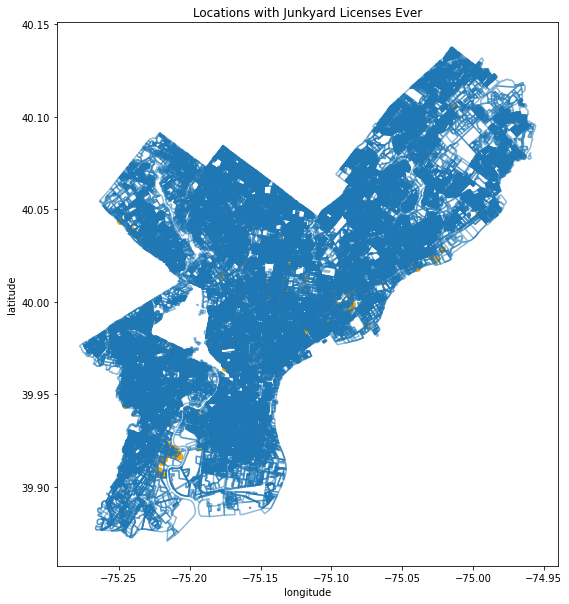

In [ ]:
#plotting licensed junkyard sites over parcels
f, ax = plt.subplots(figsize=(10,10))
ax.set_xlabel("longitude")
ax.set_ylabel("latitude")
phillyparcels.boundary.plot(ax=ax, alpha=0.5)
plt.title("Locations with Junkyard Licenses Ever")
licensedjunk.plot(ax=ax, c="Orange", alpha=1);

In [ ]:
#looking at that parcel that had a negative parcel code in the license data.
weird = phillyparcels[phillyparcels["MAPREG"]=="047S220022"]
print(weird)

            ADDR_SOURC      MAPREG  RECMAP PARCEL PWD_REVIEW DOR_REVIEW  \
413266  3103 S 61ST ST  047S220022  047S22   0022       None       None   

                                                 geometry  
413266  POLYGON ((-75.21140 39.91971, -75.21147 39.919...  


In [48]:
print("The CRS of Philadelphia parcels is:", phillyparcels.crs)


The CRS of Philadelphia parcels is: epsg:4326


In [49]:
print("The CRS of all licenses associated with junkyards is", junkyards_lic.crs)

The CRS of all licenses associated with junkyards is epsg:4326


In [50]:
print("The CRS of the junkyard licenses is:", junkyards_lic.crs)

The CRS of the junkyard licenses is: epsg:4326


In [51]:
#importing the basic boundary of Philadelphia
phillyborders = gpd.GeoDataFrame.from_file("https://opendata.arcgis.com/datasets/405ec3da942d4e20869d4e1449a2be48_0.zip")

In [52]:
print("The CRS of the border shape of Philly is:", phillyborders.crs)

The CRS of the border shape of Philly is: epsg:4326


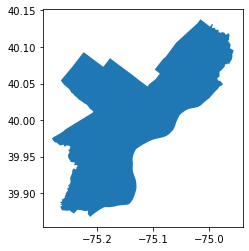

In [53]:
phillyborders.plot()

In [54]:
#converting the all-licenses dataframe to 2272
junkyards_lic_proj = junkyards_lic.to_crs("EPSG:2272")

In [55]:
# projecting the border of Philly to 2272
philly_proj = phillyborders.to_crs("EPSG:2272")

In [56]:
print("The CRS for Philly parcel data is:", phillyparcels.crs)

The CRS for Philly parcel data is: epsg:4326


In [25]:
# making projected version of Philly parcel data
phillyparc_proj = phillyparcels.to_crs("EPSG:2272")

## Joining Parcels to Full Licenses Dataframe

In [26]:
#projecting the junkyard licenses to 2272
junkyards_lic_proj = junkyards_lic.to_crs(2272)

NameError: ignored

In [ ]:
# spatial joining projected parcels and junkyard data
junkyards_licparc = phillyparc_proj.sjoin(junkyards_lic_proj, how="inner")

## Checking the results of the spatial join

In [ ]:
#joined geodataframe
junkyards_licparc.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1167 entries, 939 to 602589
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   ADDR_SOURC   1086 non-null   object  
 1   MAPREG       1167 non-null   object  
 2   RECMAP       1167 non-null   object  
 3   PARCEL       1166 non-null   object  
 4   PWD_REVIEW   154 non-null    object  
 5   DOR_REVIEW   154 non-null    object  
 6   geometry     1167 non-null   geometry
 7   index_right  1167 non-null   int64   
 8   objectid     1167 non-null   int64   
 9   addressobj   1141 non-null   float64 
 10  address      1167 non-null   object  
 11  zip          1167 non-null   object  
 12  censustrac   1167 non-null   object  
 13  parcel_id_   1092 non-null   object  
 14  opa_accoun   1051 non-null   object  
 15  opa_owner    1051 non-null   object  
 16  licensenum   1167 non-null   object  
 17  revenuecod   1167 non-null   object  
 18  licensetyp   116

In [ ]:
print("The CRS of junkyard licenses is" , licensedjunk.crs)

The CRS of junkyard licenses is epsg:4326


In [ ]:
# converting to EPSG 2272
junkliclocations = licensedjunk.to_crs(2272)

In [ ]:
#joining projected junkyard licenses to parcels
junkyardparcproj = phillyparc_proj.sjoin(junkliclocations, how="inner")

In [ ]:
junkyardparcproj.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 384 entries, 939 to 602589
Data columns (total 32 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   ADDR_SOURC   356 non-null    object  
 1   MAPREG       384 non-null    object  
 2   RECMAP       384 non-null    object  
 3   PARCEL       383 non-null    object  
 4   PWD_REVIEW   65 non-null     object  
 5   DOR_REVIEW   65 non-null     object  
 6   geometry     384 non-null    geometry
 7   index_right  384 non-null    int64   
 8   objectid     384 non-null    int64   
 9   addressobj   384 non-null    float64 
 10  address      384 non-null    object  
 11  zip          384 non-null    object  
 12  censustrac   384 non-null    object  
 13  parcel_id_   337 non-null    object  
 14  opa_accoun   322 non-null    object  
 15  opa_owner    322 non-null    object  
 16  licensenum   384 non-null    object  
 17  revenuecod   384 non-null    object  
 18  licensetyp   384 

In [ ]:
junkyardparcproj.rename({"address": "address_licdata"}, axis=1, inplace=True)

In [ ]:
junkyardparcproj = junkyardparcproj.drop(columns=["revenuecod"], axis = 1)

In [ ]:
junkyardparcproj.rename({"ADDR_SOURC": "address", "MAPREG": "parcel_full", 
                      "RECMAP": "map_section", "PARCEL": "map_parcel",
                      "PWD_REVIEW": "PWD_review", "DOR_REVIEW": "DOR_review"},
                     axis=1, inplace=True)

I kept a lot of columns before exporting. While I probably shouldn't have done that, I'm going to leave it as is for now.

In [ ]:
junkyardparcproj = junkyardparcproj[['address', 'map_section', 'map_parcel', 
                               'parcel_full', 'PWD_review', 'DOR_review',
                               'address_licdata', 'zip', 'opa_accoun', 
                               'opa_owner', 'licensenum', 'licensetyp', 
                               'initialiss', 'mostrecent', 
                               'expiration', 'inactiveda', 'licensesta', 
                               'legalfirst', 'legallastn', 'legalname', 
                               'legalentit', 'business_n', 'business_m', 
                               'geocode_x', 'geocode_y', 'geometry']]

In [ ]:
#resetting index to continuous
junkyardparcproj.reset_index(inplace = True, drop=True)

In [ ]:
junkyardparcproj.head()

address map_section map_parcel parcel_full PWD_review  \
0                 None      047S11       0010  047S110010       None   
1                 None      047S17       0035  047S170035       None   
2                 None      047S17       0026  047S170026       None   
3  6101 W PASSYUNK AVE      047S21       0023  047S210023       None   
4  6101 W PASSYUNK AVE      047S21       0044  047S210044  Completed   

  DOR_review      address_licdata         zip opa_accoun  \
0       None   6850 ESSINGTON AVE  19153-3413  884169500   
1       None   6850 ESSINGTON AVE  19153-3413  884169500   
2       None   6850 ESSINGTON AVE  19153-3413  884169500   
3       None  6101 W PASSYUNK AVE  19143-0000  882895500   
4  Completed  6101 W PASSYUNK AVE  19143-0000  882895500   

                   opa_owner  ... licensesta legalfirst legallastn  \
0  PBF LOGISTICS PRODUCTS TE  ...   Inactive       None       None   
1  PBF LOGISTICS PRODUCTS TE  ...   Inactive       None       None   
2  PBF LOGISTICS PRODUCTS TE  ...   Inactive       None       None   
3        JOES KWIK MARTS LLC  ...   Inactive       None       None   
4        JOES KWIK MARTS LLC  ...   Inactive       None       None   

             legalname legalentit           business_n  \
0  CHRIS AUTO PARTS II    Company  CHRIS AUTO PARTS II   
1  CHRIS AUTO PARTS II    Company  CHRIS AUTO PARTS II   
2  CHRIS AUTO PARTS II    Company  CHRIS AUTO PARTS II   
3  GIANNA SALVAGE CORP    Company  GIANNA SALVAGE CORP   
4  GIANNA SALVAGE CORP    Company  GIANNA SALVAGE CORP   

                                       business_m     geocode_x  \
0  6750 ESSINGTON AVE PHILADELPHIA, PA  19153 USA  2.678437e+06   
1  6750 ESSINGTON AVE PHILADELPHIA, PA  19153 USA  2.678437e+06   
2  6750 ESSINGTON AVE PHILADELPHIA, PA  19153 USA  2.678437e+06   
3  6800 ESSINGTON AVE PHILADELPHIA, PA  19153 USA  2.680928e+06   
4  6800 ESSINGTON AVE PHILADELPHIA, PA  19153 USA  2.680928e+06   

       geocode_y                                           geometry  
0  218972.547295  POLYGON ((2679160.849 219790.732, 2679137.703 ...  
1  218972.547295  POLYGON ((2678435.960 218926.501, 2678379.218 ...  
2  218972.547295  POLYGON ((2679159.954 219790.563, 2679136.835 ...  
3  223375.011346  POLYGON ((2680829.298 223301.310, 2680808.700 ...  
4  223375.011346  POLYGON ((2680825.903 223299.337, 2680819.922 ...  

[5 rows x 26 columns]

### Exporting Junkyard Locations

In [ ]:
# code I used to export that
#junkyardparcproj.to_file("/content/content/MyDrive/Colab Notebooks/PhillyJunkyardLocations.geojson", driver="GeoJSON")

In [ ]:
ls

sample_data/


# Cleaning Preprocessing Full Licenses Dataframe for Model
There are some very similar columns here and columns whose contents make no sense unless you read the metadata for their source. I'm renaming them to be a little clearer.

In [ ]:
#first renaming the business license address column, which is secondary to ADDR_SOURCE
junkyards_licparc.rename({"address": "address_licdata"}, axis=1, inplace=True)

In [ ]:
junkyards_licparc.columns

Index(['ADDR_SOURC', 'MAPREG', 'RECMAP', 'PARCEL', 'PWD_REVIEW', 'DOR_REVIEW',
       'geometry', 'index_right', 'objectid', 'addressobj', 'address_licdata',
       'zip', 'censustrac', 'parcel_id_', 'opa_accoun', 'opa_owner',
       'licensenum', 'revenuecod', 'licensetyp', 'initialiss', 'mostrecent',
       'expiration', 'inactiveda', 'licensesta', 'legalfirst', 'legallastn',
       'legalname', 'legalentit', 'business_n', 'business_m', 'geocode_x',
       'geocode_y'],
      dtype='object')

In [ ]:
#renaming the parcel data columns to be clearer and match formatting
junkyards_licparc.rename({"ADDR_SOURC": "address", "MAPREG": "parcel_full", 
                      "RECMAP": "map_section", "PARCEL": "map_parcel",
                      "PWD_REVIEW": "PWD_review", "DOR_REVIEW": "DOR_review"},
                     axis=1, inplace=True)

In [ ]:
junkyards_licparc.columns

Index(['address', 'parcel_full', 'map_section', 'map_parcel', 'PWD_review',
       'DOR_review', 'geometry', 'index_right', 'objectid', 'addressobj',
       'address_licdata', 'zip', 'censustrac', 'parcel_id_', 'opa_accoun',
       'opa_owner', 'licensenum', 'revenuecod', 'licensetyp', 'initialiss',
       'mostrecent', 'expiration', 'inactiveda', 'licensesta', 'legalfirst',
       'legallastn', 'legalname', 'legalentit', 'business_n', 'business_m',
       'geocode_x', 'geocode_y'],
      dtype='object')

I'm going to reorganize the columns and delete the ones we don't need for the model

In [ ]:
# moving geometry to end, deleting columns
junkyards_licenses = junkyards_licparc[['address', 'map_section', 'parcel_full', 
                                        'PWD_review', 'DOR_review', 'zip',
                                        'licensenum', 'licensetyp', 'geometry']]

In [ ]:
junkyards_licenses.tail()

address map_section parcel_full PWD_review  \
602589  2201-09 SPRING GARDEN ST      004N24  004N240112  Completed   
602589  2201-09 SPRING GARDEN ST      004N24  004N240112  Completed   
602589  2201-09 SPRING GARDEN ST      004N24  004N240112  Completed   
602589  2201-09 SPRING GARDEN ST      004N24  004N240112  Completed   
602589  2201-09 SPRING GARDEN ST      004N24  004N240112  Completed   

       DOR_review         zip licensenum  \
602589  Completed  19130-3511     686279   
602589  Completed  19130-3511     826075   
602589  Completed  19130-3511     826080   
602589  Completed  19130-3511     285891   
602589  Completed  19130-3511     826079   

                                             licensetyp  \
602589                            Handbill Distribution   
602589    Food Establishment, Retail Permanent Location   
602589  Motor Vehicle Repair / Retail Mobile Dispensing   
602589                              Hazardous Materials   
602589                        Auto Wrecking / Junk Yard   

                                                 geometry  
602589  POLYGON ((2690335.698 240461.367, 2690321.702 ...  
602589  POLYGON ((2690335.698 240461.367, 2690321.702 ...  
602589  POLYGON ((2690335.698 240461.367, 2690321.702 ...  
602589  POLYGON ((2690335.698 240461.367, 2690321.702 ...  
602589  POLYGON ((2690335.698 240461.367, 2690321.702 ...

In [ ]:
# "address" (0) is now the name of the correct and standard-formatting addresses
junkyards_licenses.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 1167 entries, 939 to 602589
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   address      1086 non-null   object  
 1   map_section  1167 non-null   object  
 2   parcel_full  1167 non-null   object  
 3   PWD_review   154 non-null    object  
 4   DOR_review   154 non-null    object  
 5   zip          1167 non-null   object  
 6   licensenum   1167 non-null   object  
 7   licensetyp   1167 non-null   object  
 8   geometry     1167 non-null   geometry
dtypes: geometry(1), object(8)
memory usage: 91.2+ KB


In [ ]:
#resetting index values so they're continuous
junkyards_licenses.reset_index(drop=True, inplace = True)

In [ ]:
junkyards_licenses.tail()

address map_section parcel_full PWD_review DOR_review  \
1162  2201-09 SPRING GARDEN ST      004N24  004N240112  Completed  Completed   
1163  2201-09 SPRING GARDEN ST      004N24  004N240112  Completed  Completed   
1164  2201-09 SPRING GARDEN ST      004N24  004N240112  Completed  Completed   
1165  2201-09 SPRING GARDEN ST      004N24  004N240112  Completed  Completed   
1166  2201-09 SPRING GARDEN ST      004N24  004N240112  Completed  Completed   

             zip licensenum                                       licensetyp  \
1162  19130-3511     686279                            Handbill Distribution   
1163  19130-3511     826075    Food Establishment, Retail Permanent Location   
1164  19130-3511     826080  Motor Vehicle Repair / Retail Mobile Dispensing   
1165  19130-3511     285891                              Hazardous Materials   
1166  19130-3511     826079                        Auto Wrecking / Junk Yard   

                                               geometry  
1162  POLYGON ((2690335.698 240461.367, 2690321.702 ...  
1163  POLYGON ((2690335.698 240461.367, 2690321.702 ...  
1164  POLYGON ((2690335.698 240461.367, 2690321.702 ...  
1165  POLYGON ((2690335.698 240461.367, 2690321.702 ...  
1166  POLYGON ((2690335.698 240461.367, 2690321.702 ...

In [ ]:
junkyards_licenses.nunique()

address        129
map_section     84
parcel_full    168
PWD_review       2
DOR_review       2
zip             96
licensenum     861
licensetyp      20
geometry       167
dtype: int64

In [ ]:
print("The shape of the full licenses dataset is", junkyards_licenses.shape, "rows, columns")

The shape of the full licenses dataset is (1167, 9) rows, columns


In [ ]:
junkyards_licenses[junkyards_licenses["licensenum"].isna()]

Empty GeoDataFrame
Columns: [address, map_section, parcel_full, PWD_review, DOR_review, zip, licensenum, licensetyp, geometry]
Index: []

So there are duplicate license numbers... Since it isn't that many, I assume it might be from a licensed that lapsed and was renewed being entered as two rows instead of one row with longer start and end dates. Who knows! Not really important here, because license type would still capture if a location had duplicates of the same kind.

In [ ]:
junkyards_licenses.drop(columns="licensenum", inplace=True)

/usr/local/lib/python3.8/dist-packages/pandas/core/frame.py:4906: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [ ]:
junkyards_licenses.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 1167 entries, 0 to 1166
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   address      1086 non-null   object  
 1   map_section  1167 non-null   object  
 2   parcel_full  1167 non-null   object  
 3   PWD_review   154 non-null    object  
 4   DOR_review   154 non-null    object  
 5   zip          1167 non-null   object  
 6   licensetyp   1167 non-null   object  
 7   geometry     1167 non-null   geometry
dtypes: geometry(1), object(7)
memory usage: 73.1+ KB


### Making a Column of # of Diff License Types at Location

In [ ]:
junkyards_licenses["licensetype_count"] = junkyards_licenses.groupby("parcel_full")["licensetyp"].transform('nunique')

/usr/local/lib/python3.8/dist-packages/geopandas/geodataframe.py:1443: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [ ]:
junkyards_licenses.tail()

address map_section parcel_full PWD_review DOR_review  \
1162  2201-09 SPRING GARDEN ST      004N24  004N240112  Completed  Completed   
1163  2201-09 SPRING GARDEN ST      004N24  004N240112  Completed  Completed   
1164  2201-09 SPRING GARDEN ST      004N24  004N240112  Completed  Completed   
1165  2201-09 SPRING GARDEN ST      004N24  004N240112  Completed  Completed   
1166  2201-09 SPRING GARDEN ST      004N24  004N240112  Completed  Completed   

             zip                                       licensetyp  \
1162  19130-3511                            Handbill Distribution   
1163  19130-3511    Food Establishment, Retail Permanent Location   
1164  19130-3511  Motor Vehicle Repair / Retail Mobile Dispensing   
1165  19130-3511                              Hazardous Materials   
1166  19130-3511                        Auto Wrecking / Junk Yard   

                                               geometry  licensetype_count  
1162  POLYGON ((2690335.698 240461.367, 2690321.702 ...                  5  
1163  POLYGON ((2690335.698 240461.367, 2690321.702 ...                  5  
1164  POLYGON ((2690335.698 240461.367, 2690321.702 ...                  5  
1165  POLYGON ((2690335.698 240461.367, 2690321.702 ...                  5  
1166  POLYGON ((2690335.698 240461.367, 2690321.702 ...                  5

In [ ]:
junkyards_byparcel = junkyards_licenses.groupby("parcel_full")

Turns out parcel 047S110010 is a good test to make sure I'm doing this right, since it has 5 different licenses and one of those is duplicated (dumpster)

In [ ]:
junkyards_byparcel.get_group("047S110010")

address map_section parcel_full PWD_review DOR_review         zip  \
0     None      047S11  047S110010       None       None  19153-3413   
3     None      047S11  047S110010       None       None  19153-3413   
6     None      047S11  047S110010       None       None  19153-3413   
9     None      047S11  047S110010       None       None  19153-3413   
12    None      047S11  047S110010       None       None  19153-3413   
15    None      047S11  047S110010       None       None  19153-3413   

                                         licensetyp  \
0   Motor Vehicle Repair / Retail Mobile Dispensing   
3                               Hazardous Materials   
6               Dumpster License - Private Property   
9               Dumpster License - Private Property   
12                              Scales and Scanners   
15                        Auto Wrecking / Junk Yard   

                                             geometry  licensetype_count  
0   POLYGON ((2679160.849 219790.732, 2679137.703 ...                  5  
3   POLYGON ((2679160.849 219790.732, 2679137.703 ...                  5  
6   POLYGON ((2679160.849 219790.732, 2679137.703 ...                  5  
9   POLYGON ((2679160.849 219790.732, 2679137.703 ...                  5  
12  POLYGON ((2679160.849 219790.732, 2679137.703 ...                  5  
15  POLYGON ((2679160.849 219790.732, 2679137.703 ...                  5

In [ ]:
junkyards_byparcel.head()

address map_section parcel_full PWD_review DOR_review  \
0                         None      047S11  047S110010       None       None   
1                         None      047S17  047S170035       None       None   
2                         None      047S17  047S170026       None       None   
3                         None      047S11  047S110010       None       None   
4                         None      047S17  047S170035       None       None   
...                        ...         ...         ...        ...        ...   
1162  2201-09 SPRING GARDEN ST      004N24  004N240112  Completed  Completed   
1163  2201-09 SPRING GARDEN ST      004N24  004N240112  Completed  Completed   
1164  2201-09 SPRING GARDEN ST      004N24  004N240112  Completed  Completed   
1165  2201-09 SPRING GARDEN ST      004N24  004N240112  Completed  Completed   
1166  2201-09 SPRING GARDEN ST      004N24  004N240112  Completed  Completed   

             zip                                       licensetyp  \
0     19153-3413  Motor Vehicle Repair / Retail Mobile Dispensing   
1     19153-3413  Motor Vehicle Repair / Retail Mobile Dispensing   
2     19153-3413  Motor Vehicle Repair / Retail Mobile Dispensing   
3     19153-3413                              Hazardous Materials   
4     19153-3413                              Hazardous Materials   
...          ...                                              ...   
1162  19130-3511                            Handbill Distribution   
1163  19130-3511    Food Establishment, Retail Permanent Location   
1164  19130-3511  Motor Vehicle Repair / Retail Mobile Dispensing   
1165  19130-3511                              Hazardous Materials   
1166  19130-3511                        Auto Wrecking / Junk Yard   

                                               geometry  licensetype_count  
0     POLYGON ((2679160.849 219790.732, 2679137.703 ...                  5  
1     POLYGON ((2678435.960 218926.501, 2678379.218 ...                  5  
2     POLYGON ((2679159.954 219790.563, 2679136.835 ...                  5  
3     POLYGON ((2679160.849 219790.732, 2679137.703 ...                  5  
4     POLYGON ((2678435.960 218926.501, 2678379.218 ...                  5  
...                                                 ...                ...  
1162  POLYGON ((2690335.698 240461.367, 2690321.702 ...                  5  
1163  POLYGON ((2690335.698 240461.367, 2690321.702 ...                  5  
1164  POLYGON ((2690335.698 240461.367, 2690321.702 ...                  5  
1165  POLYGON ((2690335.698 240461.367, 2690321.702 ...                  5  
1166  POLYGON ((2690335.698 240461.367, 2690321.702 ...                  5  

[666 rows x 9 columns]

In [ ]:
junkyards_byparcel.describe()

licensetype_count                                   
                        count mean  std  min  25%  50%  75%  max
parcel_full                                                     
004N240112                5.0  5.0  0.0  5.0  5.0  5.0  5.0  5.0
009S060029                2.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0
009S060032                8.0  5.0  0.0  5.0  5.0  5.0  5.0  5.0
009S060037                2.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0
009S060043                8.0  5.0  0.0  5.0  5.0  5.0  5.0  5.0
...                       ...  ...  ...  ...  ...  ...  ...  ...
150N240018                2.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0
150N240031                2.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0
150N240050                2.0  2.0  0.0  2.0  2.0  2.0  2.0  2.0
150N240056                6.0  3.0  0.0  3.0  3.0  3.0  3.0  3.0
155N090023               12.0  4.0  0.0  4.0  4.0  4.0  4.0  4.0

[168 rows x 8 columns]

In [ ]:
junkyards_address = junkyards_licenses.groupby(["address"])

In [ ]:
junkyards_address.head()

address map_section parcel_full PWD_review DOR_review  \
0                         None      047S11  047S110010       None       None   
1                         None      047S17  047S170035       None       None   
2                         None      047S17  047S170026       None       None   
3                         None      047S11  047S110010       None       None   
4                         None      047S17  047S170035       None       None   
...                        ...         ...         ...        ...        ...   
1162  2201-09 SPRING GARDEN ST      004N24  004N240112  Completed  Completed   
1163  2201-09 SPRING GARDEN ST      004N24  004N240112  Completed  Completed   
1164  2201-09 SPRING GARDEN ST      004N24  004N240112  Completed  Completed   
1165  2201-09 SPRING GARDEN ST      004N24  004N240112  Completed  Completed   
1166  2201-09 SPRING GARDEN ST      004N24  004N240112  Completed  Completed   

             zip                                       licensetyp  \
0     19153-3413  Motor Vehicle Repair / Retail Mobile Dispensing   
1     19153-3413  Motor Vehicle Repair / Retail Mobile Dispensing   
2     19153-3413  Motor Vehicle Repair / Retail Mobile Dispensing   
3     19153-3413                              Hazardous Materials   
4     19153-3413                              Hazardous Materials   
...          ...                                              ...   
1162  19130-3511                            Handbill Distribution   
1163  19130-3511    Food Establishment, Retail Permanent Location   
1164  19130-3511  Motor Vehicle Repair / Retail Mobile Dispensing   
1165  19130-3511                              Hazardous Materials   
1166  19130-3511                        Auto Wrecking / Junk Yard   

                                               geometry  licensetype_count  
0     POLYGON ((2679160.849 219790.732, 2679137.703 ...                  5  
1     POLYGON ((2678435.960 218926.501, 2678379.218 ...                  5  
2     POLYGON ((2679159.954 219790.563, 2679136.835 ...                  5  
3     POLYGON ((2679160.849 219790.732, 2679137.703 ...                  5  
4     POLYGON ((2678435.960 218926.501, 2678379.218 ...                  5  
...                                                 ...                ...  
1162  POLYGON ((2690335.698 240461.367, 2690321.702 ...                  5  
1163  POLYGON ((2690335.698 240461.367, 2690321.702 ...                  5  
1164  POLYGON ((2690335.698 240461.367, 2690321.702 ...                  5  
1165  POLYGON ((2690335.698 240461.367, 2690321.702 ...                  5  
1166  POLYGON ((2690335.698 240461.367, 2690321.702 ...                  5  

[539 rows x 9 columns]

In [ ]:
junkyards_address.get_group("2201-09 SPRING GARDEN ST")

address map_section parcel_full PWD_review DOR_review  \
1162  2201-09 SPRING GARDEN ST      004N24  004N240112  Completed  Completed   
1163  2201-09 SPRING GARDEN ST      004N24  004N240112  Completed  Completed   
1164  2201-09 SPRING GARDEN ST      004N24  004N240112  Completed  Completed   
1165  2201-09 SPRING GARDEN ST      004N24  004N240112  Completed  Completed   
1166  2201-09 SPRING GARDEN ST      004N24  004N240112  Completed  Completed   

             zip                                       licensetyp  \
1162  19130-3511                            Handbill Distribution   
1163  19130-3511    Food Establishment, Retail Permanent Location   
1164  19130-3511  Motor Vehicle Repair / Retail Mobile Dispensing   
1165  19130-3511                              Hazardous Materials   
1166  19130-3511                        Auto Wrecking / Junk Yard   

                                               geometry  licensetype_count  
1162  POLYGON ((2690335.698 240461.367, 2690321.702 ...                  5  
1163  POLYGON ((2690335.698 240461.367, 2690321.702 ...                  5  
1164  POLYGON ((2690335.698 240461.367, 2690321.702 ...                  5  
1165  POLYGON ((2690335.698 240461.367, 2690321.702 ...                  5  
1166  POLYGON ((2690335.698 240461.367, 2690321.702 ...                  5

### Deleting Duplicate License Types Per Location

In [ ]:
junkyards_licenses = junkyards_licenses.drop_duplicates(["parcel_full", "licensetyp"])

In [ ]:
junkyards_licenses.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
Int64Index: 578 entries, 0 to 1166
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   address            518 non-null    object  
 1   map_section        578 non-null    object  
 2   parcel_full        578 non-null    object  
 3   PWD_review         69 non-null     object  
 4   DOR_review         69 non-null     object  
 5   zip                578 non-null    object  
 6   licensetyp         578 non-null    object  
 7   geometry           578 non-null    geometry
 8   licensetype_count  578 non-null    int64   
dtypes: geometry(1), int64(1), object(7)
memory usage: 45.2+ KB


In [ ]:
junkyards_licenses["PWD_review"].unique()

array([None, 'Completed', 'Needed'], dtype=object)

In [ ]:
junkyards_licenses.columns

Index(['address', 'map_section', 'parcel_full', 'PWD_review', 'DOR_review',
       'zip', 'licensetyp', 'geometry', 'licensetype_count'],
      dtype='object')

## One Hot Encoding the License Types and Deleting Duplicates

In [ ]:
lic_1he = pd.get_dummies(junkyards_licenses[["map_section", "licensetyp", 
                                             "PWD_review", "DOR_review", "zip"]]).reset_index().drop("index", axis=1)
lic_1he

map_section_004N24  map_section_009S06  map_section_013S18  \
0                     0                   0                   0   
1                     0                   0                   0   
2                     0                   0                   0   
3                     0                   0                   0   
4                     0                   0                   0   
..                  ...                 ...                 ...   
573                   1                   0                   0   
574                   1                   0                   0   
575                   1                   0                   0   
576                   1                   0                   0   
577                   1                   0                   0   

     map_section_015S16  map_section_021N04  map_section_024N24  \
0                     0                   0                   0   
1                     0                   0                   0   
2                     0                   0                   0   
3                     0                   0                   0   
4                     0                   0                   0   
..                  ...                 ...                 ...   
573                   0                   0                   0   
574                   0                   0                   0   
575                   0                   0                   0   
576                   0                   0                   0   
577                   0                   0                   0   

     map_section_025S13  map_section_026S04  map_section_029S07  \
0                     0                   0                   0   
1                     0                   0                   0   
2                     0                   0                   0   
3                     0                   0                   0   
4                     0                   0                   0   
..                  ...                 ...                 ...   
573                   0                   0                   0   
574                   0                   0                   0   
575                   0                   0                   0   
576                   0                   0                   0   
577                   0                   0                   0   

     map_section_030N13  ...  zip_19153-3503  zip_19153-3506  zip_19153-3507  \
0                     0  ...               0               0               0   
1                     0  ...               0               0               0   
2                     0  ...               0               0               0   
3                     0  ...               0               0               0   
4                     0  ...               0               0               0   
..                  ...  ...             ...             ...             ...   
573                   0  ...               0               0               0   
574                   0  ...               0               0               0   
575                   0  ...               0               0               0   
576                   0  ...               0               0               0   
577                   0  ...               0               0               0   

     zip_19153-3508  zip_19153-3513  zip_19153-3516  zip_19153-3522  \
0                 0               0               0               0   
1                 0               0               0               0   
2                 0               0               0               0   
3                 0               0               0               0   
4                 0               0               0               0   
..              ...             ...             ...             ...   
573               0               0               0               0   
574               0               0               0          

In [ ]:
licenses_ohe = junkyards_licenses[['parcel_full', 'geometry', 
                                   'licensetype_count']].reset_index().drop("index", 
                                                                                   axis=1).join(lic_1he)
licenses_ohe.shape

(578, 207)

In [ ]:
licenses_ohe.head()

parcel_full                                           geometry  \
0  047S110010  POLYGON ((2679160.849 219790.732, 2679137.703 ...   
1  047S170035  POLYGON ((2678435.960 218926.501, 2678379.218 ...   
2  047S170026  POLYGON ((2679159.954 219790.563, 2679136.835 ...   
3  047S110010  POLYGON ((2679160.849 219790.732, 2679137.703 ...   
4  047S170035  POLYGON ((2678435.960 218926.501, 2678379.218 ...   

   licensetype_count  map_section_004N24  map_section_009S06  \
0                  5                   0                   0   
1                  5                   0                   0   
2                  5                   0                   0   
3                  5                   0                   0   
4                  5                   0                   0   

   map_section_013S18  map_section_015S16  map_section_021N04  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   0                   0   
4                   0                   0                   0   

   map_section_024N24  map_section_025S13  ...  zip_19153-3503  \
0                   0                   0  ...               0   
1                   0                   0  ...               0   
2                   0                   0  ...               0   
3                   0                   0  ...               0   
4                   0                   0  ...               0   

   zip_19153-3506  zip_19153-3507  zip_19153-3508  zip_19153-3513  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   zip_19153-3516  zip_19153-3522  zip_19153-3524  zip_19153-3529  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   zip_19153-3588  
0               0  
1               0  
2               0  
3               0  
4               0  

[5 rows x 207 columns]

In [ ]:
licenses_ohe2 = licenses_ohe.groupby("parcel_full").max()

<ipython-input-101-a95b6da724f4>:1: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  licenses_ohe2 = licenses_ohe.groupby("parcel_full").max()


In [ ]:
licenses_ohe2

licensetype_count  map_section_004N24  map_section_009S06  \
parcel_full                                                              
004N240112                   5                   1                   0   
009S060029                   2                   0                   1   
009S060032                   5                   0                   1   
009S060037                   2                   0                   1   
009S060043                   5                   0                   1   
...                        ...                 ...                 ...   
150N240018                   2                   0                   0   
150N240031                   2                   0                   0   
150N240050                   2                   0                   0   
150N240056                   3                   0                   0   
155N090023                   4                   0                   0   

             map_section_013S18  map_section_015S16  map_section_021N04  \
parcel_full                                                               
004N240112                    0                   0                   0   
009S060029                    0                   0                   0   
009S060032                    0                   0                   0   
009S060037                    0                   0                   0   
009S060043                    0                   0                   0   
...                         ...                 ...                 ...   
150N240018                    0                   0                   0   
150N240031                    0                   0                   0   
150N240050                    0                   0                   0   
150N240056                    0                   0                   0   
155N090023                    0                   0                   0   

             map_section_024N24  map_section_025S13  map_section_026S04  \
parcel_full                                                               
004N240112                    0                   0                   0   
009S060029                    0                   0                   0   
009S060032                    0                   0                   0   
009S060037                    0                   0                   0   
009S060043                    0                   0                   0   
...                         ...                 ...                 ...   
150N240018                    0                   0                   0   
150N240031                    0                   0                   0   
150N240050                    0                   0                   0   
150N240056                    0                   0                   0   
155N090023                    0                   0                   0   

             map_section_029S07  ...  zip_19153-3503  zip_19153-3506  \
parcel_full                      ...                                   
004N240112                    0  ...               0               0   
009S060029                    0  ...               0               0   
009S060032                    0  ...               0               0   
009S060037                    0  ...               0               0   
009S060043                    0  ...               0               0   
...                         ...  ...             ...             ...   
150N240018                    0  ...               0               0   
150N240031                    0  ...               0               0   
150N240050                    0  ...               0               0   
150N240056                    0  ...               0               0   
155N090023                    0  ...               0               0   

             zip_19153-3507  zip_19153-3508  zip_19153-3513  zip_19153-3516  \
parcel_full                                                                   
004

In [ ]:
licenses_ohe3 = licenses_ohe.groupby("parcel_full").agg("max")

/usr/local/lib/python3.8/dist-packages/pandas/core/apply.py:577: FutureWarning: Dropping invalid columns in DataFrameGroupBy.max is deprecated. In a future version, a TypeError will be raised. Before calling .max, select only columns which should be valid for the function.
  return f(*args, **kwargs)


In [ ]:
licenses_ohe3

licensetype_count  map_section_004N24  map_section_009S06  \
parcel_full                                                              
004N240112                   5                   1                   0   
009S060029                   2                   0                   1   
009S060032                   5                   0                   1   
009S060037                   2                   0                   1   
009S060043                   5                   0                   1   
...                        ...                 ...                 ...   
150N240018                   2                   0                   0   
150N240031                   2                   0                   0   
150N240050                   2                   0                   0   
150N240056                   3                   0                   0   
155N090023                   4                   0                   0   

             map_section_013S18  map_section_015S16  map_section_021N04  \
parcel_full                                                               
004N240112                    0                   0                   0   
009S060029                    0                   0                   0   
009S060032                    0                   0                   0   
009S060037                    0                   0                   0   
009S060043                    0                   0                   0   
...                         ...                 ...                 ...   
150N240018                    0                   0                   0   
150N240031                    0                   0                   0   
150N240050                    0                   0                   0   
150N240056                    0                   0                   0   
155N090023                    0                   0                   0   

             map_section_024N24  map_section_025S13  map_section_026S04  \
parcel_full                                                               
004N240112                    0                   0                   0   
009S060029                    0                   0                   0   
009S060032                    0                   0                   0   
009S060037                    0                   0                   0   
009S060043                    0                   0                   0   
...                         ...                 ...                 ...   
150N240018                    0                   0                   0   
150N240031                    0                   0                   0   
150N240050                    0                   0                   0   
150N240056                    0                   0                   0   
155N090023                    0                   0                   0   

             map_section_029S07  ...  zip_19153-3503  zip_19153-3506  \
parcel_full                      ...                                   
004N240112                    0  ...               0               0   
009S060029                    0  ...               0               0   
009S060032                    0  ...               0               0   
009S060037                    0  ...               0               0   
009S060043                    0  ...               0               0   
...                         ...  ...             ...             ...   
150N240018                    0  ...               0               0   
150N240031                    0  ...               0               0   
150N240050                    0  ...               0               0   
150N240056                    0  ...               0               0   
155N090023                    0  ...               0               0   

             zip_19153-3507  zip_19153-3508  zip_19153-3513  zip_19153-3516  \
parcel_full                                                                   
004

In [ ]:
licenses_ohe3.reset_index()

parcel_full  licensetype_count  map_section_004N24  map_section_009S06  \
0    004N240112                  5                   1                   0   
1    009S060029                  2                   0                   1   
2    009S060032                  5                   0                   1   
3    009S060037                  2                   0                   1   
4    009S060043                  5                   0                   1   
..          ...                ...                 ...                 ...   
163  150N240018                  2                   0                   0   
164  150N240031                  2                   0                   0   
165  150N240050                  2                   0                   0   
166  150N240056                  3                   0                   0   
167  155N090023                  4                   0                   0   

     map_section_013S18  map_section_015S16  map_section_021N04  \
0                     0                   0                   0   
1                     0                   0                   0   
2                     0                   0                   0   
3                     0                   0                   0   
4                     0                   0                   0   
..                  ...                 ...                 ...   
163                   0                   0                   0   
164                   0                   0                   0   
165                   0                   0                   0   
166                   0                   0                   0   
167                   0                   0                   0   

     map_section_024N24  map_section_025S13  map_section_026S04  ...  \
0                     0                   0                   0  ...   
1                     0                   0                   0  ...   
2                     0                   0                   0  ...   
3                     0                   0                   0  ...   
4                     0                   0                   0  ...   
..                  ...                 ...                 ...  ...   
163                   0                   0                   0  ...   
164                   0                   0                   0  ...   
165                   0                   0                   0  ...   
166                   0                   0                   0  ...   
167                   0                   0                   0  ...   

     zip_19153-3503  zip_19153-3506  zip_19153-3507  zip_19153-3508  \
0                 0               0               0               0   
1                 0               0               0               0   
2                 0               0               0               0   
3                 0               0               0               0   
4                 0               0               0               0   
..              ...             ...             ...             ...   
163               0               0               0               0   
164               0               0               0               0   
165               0               0               0               0   
166               0               0               0               0   
167               0               0               0               0   

     zip_19153-3513  zip_19153-3516  zip_19153-3522  zip_19153-3524  \
0                 0               0               0               0   
1                 0               0               0               0   
2                 0               0               0               0   
3                 0               0               0               0   
4                 0               0               0               0   
..              ...             ...             ...             ...   
163               0               0            

### Rejoining with Geometry

In [ ]:
geometry = licenses_ohe[["parcel_full", "geometry"]]

In [ ]:
geometry.describe()

parcel_full                                           geometry
count          578                                                578
unique         168                                                167
top     047S210049  POLYGON ((2680783.132597672 223162.62218585834...
freq             9                                                  9

In [ ]:
geometry = geometry.drop_duplicates(subset=["parcel_full"], keep='first')
geometry

parcel_full                                           geometry
0    047S110010  POLYGON ((2679160.849 219790.732, 2679137.703 ...
1    047S170035  POLYGON ((2678435.960 218926.501, 2678379.218 ...
2    047S170026  POLYGON ((2679159.954 219790.563, 2679136.835 ...
15   047S210023  POLYGON ((2680829.298 223301.310, 2680808.700 ...
16   047S210044  POLYGON ((2680825.903 223299.337, 2680819.922 ...
..          ...                                                ...
552  009S060032  POLYGON ((2684634.992 231397.724, 2684640.581 ...
561  111N220010  POLYGON ((2727858.623 261131.420, 2727876.458 ...
566  047S200080  POLYGON ((2680390.397 223711.413, 2680288.056 ...
568  047S200071  POLYGON ((2679266.293 223243.072, 2679413.183 ...
573  004N240112  POLYGON ((2690335.698 240461.367, 2690321.702 ...

[168 rows x 2 columns]

In [ ]:
geometry.reset_index(drop=True)

parcel_full                                           geometry
0    047S110010  POLYGON ((2679160.849 219790.732, 2679137.703 ...
1    047S170035  POLYGON ((2678435.960 218926.501, 2678379.218 ...
2    047S170026  POLYGON ((2679159.954 219790.563, 2679136.835 ...
3    047S210023  POLYGON ((2680829.298 223301.310, 2680808.700 ...
4    047S210044  POLYGON ((2680825.903 223299.337, 2680819.922 ...
..          ...                                                ...
163  009S060032  POLYGON ((2684634.992 231397.724, 2684640.581 ...
164  111N220010  POLYGON ((2727858.623 261131.420, 2727876.458 ...
165  047S200080  POLYGON ((2680390.397 223711.413, 2680288.056 ...
166  047S200071  POLYGON ((2679266.293 223243.072, 2679413.183 ...
167  004N240112  POLYGON ((2690335.698 240461.367, 2690321.702 ...

[168 rows x 2 columns]

In [ ]:
licenses_ohe_full = pd.merge(geometry, licenses_ohe3, on="parcel_full")

In [ ]:
licenses_ohe_full.head()

parcel_full                                           geometry  \
0  047S110010  POLYGON ((2679160.849 219790.732, 2679137.703 ...   
1  047S170035  POLYGON ((2678435.960 218926.501, 2678379.218 ...   
2  047S170026  POLYGON ((2679159.954 219790.563, 2679136.835 ...   
3  047S210023  POLYGON ((2680829.298 223301.310, 2680808.700 ...   
4  047S210044  POLYGON ((2680825.903 223299.337, 2680819.922 ...   

   licensetype_count  map_section_004N24  map_section_009S06  \
0                  5                   0                   0   
1                  5                   0                   0   
2                  5                   0                   0   
3                  6                   0                   0   
4                  6                   0                   0   

   map_section_013S18  map_section_015S16  map_section_021N04  \
0                   0                   0                   0   
1                   0                   0                   0   
2                   0                   0                   0   
3                   0                   0                   0   
4                   0                   0                   0   

   map_section_024N24  map_section_025S13  ...  zip_19153-3503  \
0                   0                   0  ...               0   
1                   0                   0  ...               0   
2                   0                   0  ...               0   
3                   0                   0  ...               0   
4                   0                   0  ...               0   

   zip_19153-3506  zip_19153-3507  zip_19153-3508  zip_19153-3513  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   zip_19153-3516  zip_19153-3522  zip_19153-3524  zip_19153-3529  \
0               0               0               0               0   
1               0               0               0               0   
2               0               0               0               0   
3               0               0               0               0   
4               0               0               0               0   

   zip_19153-3588  
0               0  
1               0  
2               0  
3               0  
4               0  

[5 rows x 207 columns]

In [ ]:
#licenses_ohe_full

In [ ]:
#did this to make sure the DOR review and PWD review columns got in there
#licenses_ohe_full.columns.tolist()

## Exporting One Hot Encoded License Data as GeoJSON

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
drive.mount("content")

Mounted at content


In [ ]:
cd /content/content/MyDrive/Colab Notebooks

/content/content/MyDrive/Colab Notebooks


In [ ]:
ls

 09_26Class_Geopandas.ipynb
 09_28_Class_MoreGeoPandas.ipynb
 10_03_Class_LinearRegression.ipynb
 AutocorrelationCensus.ipynb
'Carl Jung.jpg'
 ClassDemoBusTimes.ipynb
'Copy of MidtermLathamWolk DEPDataNotebook.ipynb'
'HW3 HW3.ipynb'
'HW4 HW4.ipynb'
'HW5 HW5_TimeSeriesClustering.ipynb'
'HW6\HW6_RandomForestsChicago (1).ipynb'
'HW6\HW6_RandomForestsChicago.ipynb'
'HW6\HW6_RandomForestsDC.ipynb'
'HW6\HW6_RandomForestsDC Take 2.ipynb'
'HW7 HW7_deepdream.ipynb'
'HW HW5_timeSeriesClustering.ipynb'
 JunkyardViolations_OHE.geojson
 kaggle.json
'MidtermLathamWolk 311 Requests Notebook.ipynb'
'MidtermLathamWolk DEPDataNotebook.ipynb'
'MidtermLathamWolk JunkyardFireModel.ipynb'
'MidtermLathamWolk LanthamWolkMidtermData.ipynb'
'MidtermLathamWolk LIBusinessLicenses.ipynb'
'MidtermLathamWolk LIViolations.ipynb'
 PhillyJunkLicensesLocations.csv
 PhillyJunkLicensesLocations.geojson
 PhillyJunkyardLocations.geojson
 PUS2022_1031_MoransINYCWomens.ipynb
 PUS22_Class2and3.ipynb
 TitanicKaggleFraggleRockDa

In [ ]:
licenses_ohe_full.to_file("/content/content/MyDrive/Colab Notebooks/PhillyBusinessLicensesOHE.geojson", driver="GeoJSON")

## Exporting Junkyard Business License Data and Locations (didn't use this, used OHE data)

In [48]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [49]:
drive.mount("content")

Mounted at content


In [ ]:
cd /content/content/MyDrive/Colab Notebooks

In [ ]:
ls

In [ ]:
#exporting dataframe to my Google Drive Colab folder as a GeoJSON
#your filepath may be different! Name the file however you want at the end
phillyjunklic.to_file("/content/content/MyDrive/Colab Notebooks/PhillyJunkLicensesLocations.geojson", driver="GeoJSON")

## Plotting Junkyard Parcels (not sure where this goes)

### Conclusions about how to connect all the other data: use parcels, not address!
Parcel_full is probably the most authoritative and useful column. 

As you can see from the head of the dataframe, some parcels have no address even in the official parcel + address records. From looking at this data in another notebook, some parcels have multiple addresses attached. For example, "120-130 Bigparcel St" could be an address for one parcel, and then bad records or businesses sharing a site might use 123 Bigparcel St and 125 Bigparcel St for the same piece of land or even the same business. However, some addresses also have multiple parcels! See 3111 Grays Ferry Ave when I group by parcel below: it shows up as the address for multiple parcels. That address is a junkyard under I-76 and next to a freight line, so it's no surprise that it's a very weird lot.

Since some parcels have no address and the parcels have more systematic naming, the simplest way to deal with this for the full set of data is just using parcels.

Also, using parcels as a join key instead of geometry is a little more reliable (no CRS conversions or tiny numbers) and faster.

In [ ]:
#grouping by parcel
junkyparcels = phillyjunklic.groupby("parcel_full").first()

In [ ]:
f, ax = plt.subplots(figsize=(20,20))
ax.set_xlabel("feet easting")
ax.set_ylabel("feet northing")
plt.title("Junkyard tracts over Philly")
junkyparcels.plot(ax=ax, color="Orange")
philly_proj.boundary.plot(ax=ax, alpha=0.5)

Unsurprisingly, the junkyards are concentrated in Southwest Philly, the Riverwards near the Delaware River, and North Philly.

# Not Important: Creating Dataframe of active junkyard licenses for later and comparison

In [ ]:
#extracting active junkyard licenses
activejunk = licensedjunk[licensedjunk["licensesta"] == "Active"]

In [ ]:
activejunk

There are 52 entries with active junkyard licenses. This probably corresponds better to unique sites than the all licenses data, but we'll find out!

In [ ]:
licensedjunk.info()

In [ ]:
licensedjunk.nunique()

Only 125 unique geometry points out of 269 rows! You can also see that almost every other unique identifier is missing rows. Addressobj has the most nuniques, though, so I'm going to hope that's the most comprehensive.

In [ ]:
activejunk.nunique()

In some code I deleted, I was trying to get a sense of how much business name, address, and parcel are the same. For example, will the same business name mostly have the same address and parcel, or will it have such varied addresses that we'd need to look for bad data or changes of business location? Will the same parcel have a consistent address? Will the same address have a consistent parcel? This isn't necessarily important to our research at the moment, but it's something to dig into more if we go further.